In [6]:
%load_ext autoreload

%autoreload 2

import os
import sys
sys.path.append('../src')
os.chdir('../src')
from raving_fader.models import CRAVE
from raving_fader.helpers.core import load_config
from raving_fader.config import *
from raving_fader.helpers.eval import *
from raving_fader.pipelines import pipelines
from audio_descriptors.features import compute_all
from raving_fader.datasets.attr_dataset import get_dataset_attr
from torch.utils.data import DataLoader, random_split
import torch
import cdpam#Compute the losses
    distance = model.distance(
        x, y).item()  # Multiscale STFT distance (training loss)
    results["distance"] += distance / len(validloader)
from tqdm import tqdm
import torchaudio.transforms as T
os.environ["CUDA_VISIBLE_DEVICES"]="2"
settings.CUDA_VISIBLE_DEVICES=2
settings.NUM_WORKERS=1
eval_path="/data/nils/darbouka/processed/"
configfile = "/data/nils/raving_fader_eval/config/dataconfigs/eval_conf_darbouka.yaml"
models_path = '/data/nils/raving_fader_eval/models/' 
from scipy import stats

var_percent = [.8, .9,.95]
torch.set_grad_enabled(False)




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
models_names =["CRAVE_DK_multi"]
addon = "800000"
results_folder = "DK_1_C"

swap_descr = None

n_passes = 5
jnd = False

swaps = [1]
nb_ex = 1000

In [17]:

# allfeatures_reference = torch.load(os.path.join(eval_path,"FRAVE_multi_features.pth"))
# allfeatures_reference = allfeatures_reference[:,[0,2,1,3,4],:]
# descriptors =["centroid","rms","bandwidth","sharpness","booming"]
# min_max_ref = {}
# for i,descr in enumerate(descriptors):
#     min_max_ref[descr] = [np.min(allfeatures_reference[:,i,:]),np.max(allfeatures_reference[:,i,:])]
    
# eval_dataset,eval_loader = get_evalset(eval_path,configfile,batch=8)

allfeatures_reference = torch.load(os.path.join(eval_path,"FRAVE_DK_multi_features.pth"))
# allfeatures_reference = allfeatures_reference[:,[0,2,1,3,4],:]
descriptors =["centroid","rms","bandwidth","sharpness","booming"]
min_max_ref = {}
for i,descr in enumerate(descriptors):
    min_max_ref[descr] = [np.min(allfeatures_reference[:,i,:]),np.max(allfeatures_reference[:,i,:])]
    
eval_dataset,eval_loader = get_evalset(eval_path,configfile,batch=8,eval_file="FRAVE_DK_multi_features.pth")


train, val = random_split(
    eval_dataset,
    [nb_ex, len(eval_dataset)-nb_ex],
    generator=torch.Generator().manual_seed(42),
)

# eval_dataset=train
eval_loader = DataLoader(train,
                   8,
                   True,
                   drop_last=True,
                   num_workers=1)

initialize=0 num_lat_dis_layers=2 rave_ckpt=None clip_grad_norm=0 num_classes=16
features imported


In [18]:
# !export CUDA_VISIBLE_DEVICES=0

In [19]:
def create_funcs(features_swapped):
    n_points = 64
    # Lots of basic funcs
    zeros = np.zeros(n_points)
    ones = np.ones(n_points)
    ones_m = np.ones(n_points) * -1 
    linear = np.linspace(-1, 1, n_points)
    linear_inv = np.linspace(1, -1, n_points)
    # Selector array
    basic_funcs = [zeros, ones, ones_m, linear, linear_inv]
    # Sinusoid generator
    sin_funcs = []
    for i in range(10):
        freq = np.random.randint(1, 30)
        phase = np.random.randn() * 2 * np.pi
        sin_rnd = np.sin((linear * freq) + phase)
        sin_funcs.append(sin_rnd)

    # Interpolator
    sel_1 = basic_funcs[np.random.randint(0, len(basic_funcs))]
    sel_2 = sin_funcs[np.random.randint(0, len(sin_funcs))]
    alphas = np.linspace(0., 1., 10)
    int_funcs = []
    for alpha in alphas:
        int_sig = alpha * sel_2 + ((1 - alpha) * sel_1)
        int_funcs.append(int_sig)

    # Interpolator

    sel_1,sel_2 = features_swapped[0].cpu().numpy(),features_swapped[1].cpu().numpy()
    # plt.plot(sel_1)
    # plt.plot(sel_2)
    alphas = np.linspace(0., 1., 50)
    eval_funcs = []
    for alpha in alphas:
        int_sig = alpha * sel_2 + ((1 - alpha) * sel_1)
        eval_funcs.append(int_sig)

    full_funcs = [item for sub in [basic_funcs, sin_funcs, int_funcs, eval_funcs] for item in sub]
    full_funcs=  torch.tensor(np.array(full_funcs))
    
    return full_funcs.unsqueeze(1).float()

In [20]:
for nb_swap in swaps:
    df = pd.DataFrame(index=models_names)
    for p in var_percent:
        df["Manifold "+str(100*p)+" %"] = ""
    #Losses 
    df["step"] = ""
    df["JND"]=""
    df["Mel Spec"] = ""
    df["MScale STFT"] = ""
    df["mean_corr"] = ""
    df["mean_l1"] = ""
    df["mean_l2"] = ""
    df["mean_corr_stats"] = ""
    
    df["Cycle Consistency"] = "" 
    for descr in descriptors:
        df["Control Corr_"+descr] = ""
        df["Control l1_"+descr] = ""
        df["Control l2_"+descr] = ""
        df["feat_corr_stats_"+descr] = ""

    for model_name in models_names:
        model_dir = os.path.join(models_path,model_name)
        try:
            ckpt = os.path.join(model_dir,model_name+"__vae_"+addon+".ckpt")
            config_file = os.path.join(model_dir,"train_config.yaml")
            config,pipeline,model,checkpoint=load_model(config_file,ckpt,datapath=None,batch_size=8)
        except:
            ckpt = os.path.join(model_dir,model_name+"__vae"+".ckpt")
            config_file = os.path.join(model_dir,"train_config.yaml")
            config,pipeline,model,checkpoint=load_model(config_file,ckpt,datapath=None,batch_size=8)
        print(ckpt)
        
        # model= model.to(pipeline.device)
        
        resampler = T.Resample(16000, 44100).to(pipeline.device)


        model.encoder.eval()
        model.decoder.eval()
        model_descriptors = config.data.descriptors
        for i,descr in enumerate(model_descriptors):
            if descr=='bandwith':
                model_descriptors[i]="bandwidth"

        vals = latent_space_pca_analysis(model, eval_loader, latent_dim=128)

        indices=[]
        for descr in config.data.descriptors:
            indices.append(descriptors.index(descr))


        mel,jnd,distance = 0,0,0
        feat_l1loss = dict.fromkeys(model.descriptors,0)
        feat_l2loss = dict.fromkeys(model.descriptors,0)
        feat_corr_stats = dict.fromkeys(model.descriptors,0)
        feat_corr = dict.fromkeys(model.descriptors,0)
        loss_fn_jnd = cdpam.CDPAM(dev=pipeline.device)
        all_swapped,all_in,all_out,id_swaps = [],[],[],[]
        for j in range(n_passes):
            for x,features in tqdm(eval_loader):
                x = x.to(pipeline.device)
                features = features.to(pipeline.device)
                features_norm = features[:,indices]

                for i,descr in enumerate(model.descriptors):                
                        features_norm[:,i] = eval_dataset.normalize(features_norm[:,i],min_max_ref[descr])   

                y = forward_eval(model,x,features_norm)

                mel += get_mel_loss(model,x, y, nfft=2048, nmels=512, hop_length=512, win_length=2048).item()
                if jnd==True:
                    jnd += get_jnd_loss(model,x,y,loss_fn_jnd)
                distance += model.distance(x.unsqueeze(1),y.unsqueeze(1))

                #Swap Attributes


                features_all = allfeatures_reference
                

                    
                features_final = features_norm.clone()
                
                ch = [i for i, d in enumerate(model.descriptors) if d != "bandwidth"]
                id_descr = np.random.choice(ch,nb_swap,replace=False)    
                
                for j in id_descr:
                    id_random = np.random.choice(range(len(features_all)),2)
                    features_swapped = torch.tensor(features_all[id_random,:]).to(pipeline.device)
                    for i,descr in enumerate(descriptors):                
                        features_swapped[:,i]= eval_dataset.normalize(features_swapped[:,i],min_max_ref[descr])
                    
                    features_swapped = features_swapped[:,indices[j],:]
                    features_pool = create_funcs(features_swapped).to(pipeline.device)
                    id_random = np.random.choice(range(len(features_pool)),len(x))
                    

                    features_final[:,j] = features_pool[id_random,:].squeeze(1)

                    
                    
                    
                # else:
                #     features_swapped = features.clone()
                #     features_swapped[:,swap_descr] = torch.tensor(features_pool[id_random,swap_descr]).to(model.device)

                # features_swapped=features_swapped[:,indices]

                #Compute y
                # for i,descr in enumerate(model.descriptors):                
                #         features_swapped[:,i] = eval_dataset.normalize(features_swapped[:,i],min_max_ref[descr]) 

                
                
                y_swap = forward_eval(model,x,features_final)


                #Compute features
                features_out = torch.zeros_like(features_final)
                
                
                # if "booming" in model.descriptors or "sharpness" in model.descriptors:
                #     y_swap = resampler(y_swap)
                    
                for i,signal in enumerate(y_swap):
                    feat = compute_all(signal.cpu().numpy(),sr=48000,
                                                            descriptors=model.descriptors,
                                                            mean=False,
                                                            resample=eval_dataset.latent_length)
                    
                    
                    feat = {descr: feat[descr] for descr in model.descriptors}
                    feature_arr = np.array(list(feat.values())).astype(np.float32)
                    features_out[i] = torch.tensor(feature_arr)  

                #Normalize features
                for i,descr in enumerate(model.descriptors):                
                        features_out[:,i] = eval_dataset.normalize(features_out[:,i],min_max_ref[descr]) 

                #Compute Correlation
                for i,descr in enumerate(model.descriptors):
                    feat_out = features_out[:,i]
                    feat_in = features_final[:,i]
                    feat_l1loss[descr] += F.l1_loss(feat_in,feat_out).item()/len(eval_loader)/n_passes
                    feat_l2loss[descr] += F.mse_loss(feat_in,feat_out).item()/len(eval_loader)/n_passes
                    
                    cos = torch.nn.CosineSimilarity(dim=0 ,eps=1e-6)
                   #feat_corr[descr] += (cos(feat_in.reshape(-1)-feat_in.mean(),feat_out.reshape(-1)-feat_out.mean())/len(eval_loader)).item()   
                    feat_corr[descr] += (((cos(feat_in.reshape(-1)-feat_in.mean(),feat_out.reshape(-1)-feat_out.mean()) + 1) / 2) /len(eval_loader)).item()/n_passes
                    
                    
                    for ex in range(len(features_final)):
                        val = stats.pearsonr(feat_out[ex].cpu(),feat_in[ex].cpu())[0]/n_passes/len(eval_loader)/len(features_final)
                        if np.isnan(val):
                            feat_corr_stats[descr] += 0
                        else:
                            feat_corr_stats[descr] += val
                            
                

                #Swap Attributes2
                id_swaps.append(np.expand_dims(id_descr,1).T.repeat(8,axis=0))
                all_swapped.append(features_final.cpu())
                all_in.append(features_norm.cpu())
                all_out.append(features_out.cpu())
                
                
        d_save = {"swapped":torch.cat(all_swapped),"in":torch.cat(all_in),"out":torch.cat(all_out),"id_swaps":np.array(id_swaps),"descriptors":model.descriptors}
        torch.save(d_save,os.path.join(models_path,results_folder+"/"+model_name+'_'+str(nb_swap)+".pth"))

        mean_corr,mean_l1,mean_l2,mean_corr_stats=0,0,0,0
        for descr in model.descriptors:
            mean_corr += feat_corr[descr]/len(model.descriptors)
            mean_l1 += feat_l1loss[descr]/len(model.descriptors)
            mean_l2 += feat_l2loss[descr]/len(model.descriptors)
            mean_corr_stats += feat_corr_stats[descr]/len(model.descriptors)
            
        df["JND"][model_name]=jnd/len(eval_loader)/n_passes
        df["Mel Spec"][model_name] = mel/len(eval_loader)/n_passes
        df["MScale STFT"][model_name] = distance.item()/len(eval_loader)/n_passes
        
        df["mean_corr"][model_name] = mean_corr
        df["mean_l1"][model_name] = mean_l1
        df["mean_l2"][model_name] = mean_l2
        df["mean_corr_stats"][model_name] = mean_corr_stats

        for val,p in zip(vals,var_percent):
            df["Manifold "+str(100*p)+" %"][model_name] = val

        for descr in model.descriptors:
            df["Control Corr_"+descr][model_name]=feat_corr[descr]
            df["Control l1_"+descr][model_name]=feat_l1loss[descr]
            df["Control l2_"+descr][model_name]=feat_l2loss[descr]
            df["feat_corr_stats_"+descr][model_name]= feat_corr_stats[descr]
        
        
        df["step"][model_name] = checkpoint["step"]

        torch.save(df,os.path.join(models_path,results_folder+'/'+str(nb_swap)+".pth"))

/data/nils/raving_fader_eval/models/CRAVE_DK_multi/CRAVE_DK_multi__vae_800000.ckpt


  0%|                                                                                                                                                                                     | 0/125 [00:00<?, ?it/s]/data/nils/miniconda3/lib/python3.9/site-packages/torchaudio/functional/functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(
/data/nils/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
  1%|█▍                                                                                                                                                                           | 1/125 [00:01<03:52,  1.87s/it]/data/nils/miniconda3/lib/python3.9/site-packages/torchaudio/functional/fu

array([[3, 0, 2],
       [3, 0, 2],
       [3, 0, 2],
       [3, 0, 2],
       [3, 0, 2],
       [3, 0, 2],
       [3, 0, 2],
       [3, 0, 2]])

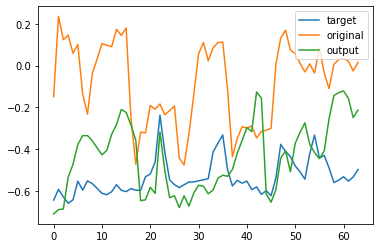

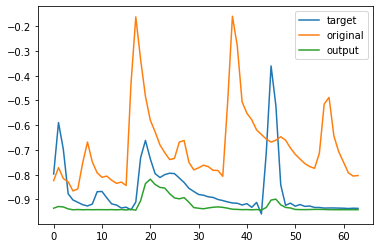

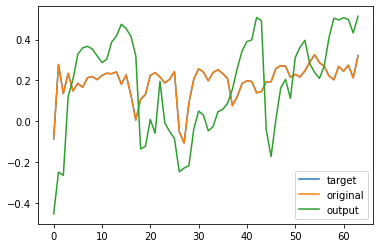

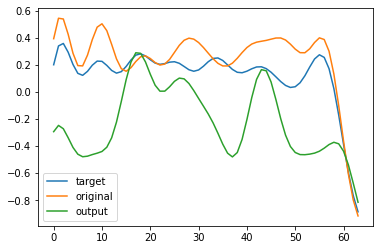

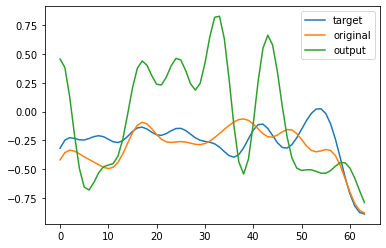

In [21]:
swapped = features_final.cpu().numpy()
true = features_norm.cpu().numpy()
out = features_out.cpu().numpy()
ex =1

for i,descr in enumerate(model.descriptors):
    plt.figure()
    plt.plot(swapped[ex,i],label="target")
    plt.plot(true[ex,i],label="original")
    plt.plot(out[ex,i],label="output")
    plt.legend()

In [ ]:
swapped.shape

In [10]:
plt.plot(features_swapped[2,0].cpu().numpy())
plt.plot(features_out[2,0].cpu().numpy())

NameError: name 'features_swapped' is not defined

In [ ]:
import torchaudio.transforms as T
import time
import librosa
s = time.time()

for i in range(10):

    resampler = T.Resample(16000, 44100).to(model.device)
    resampled_waveform = resampler(x)
    resampled_waveform.shape
print(time.time()-s)

s = time.time()

for i in range(10):
    for signal in x.cpu().numpy():
        y = librosa.core.resample(signal,16000,target_sr=44100)
        
print(time.time()-s)


In [ ]:
print('hi')

/data/nils/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(nan, nan)
0.7094001770019531
0.6601628661155701
1.1755441953198442e-08


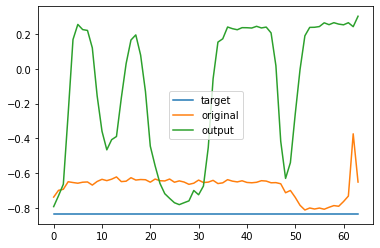

(0.1098658287748987, 0.3874648393531577)
0.2686149775981903
0.11544620990753174
0.10986582189798355


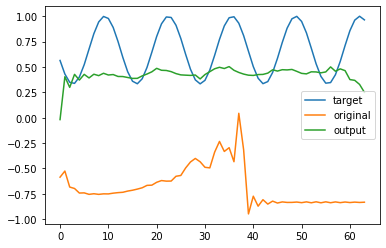

(0.4296302855366832, 0.0003958865541532106)
0.28767672181129456
0.11757821589708328
0.4296302795410156


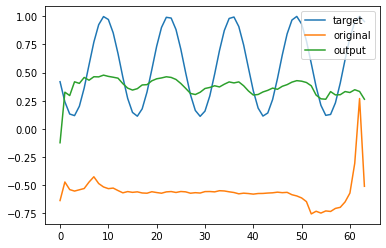

(-0.7661837050018038, 1.615240024877223e-13)
0.7873591184616089
0.7436091899871826
-0.7661831378936768


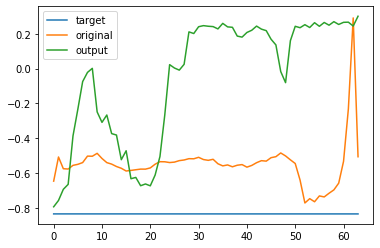

(nan, nan)
0.5036601424217224
0.2580357491970062
0.0


/data/nils/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


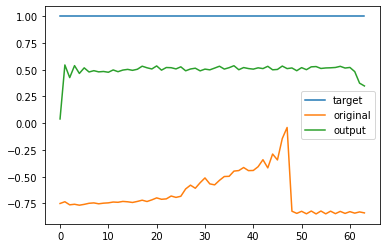

/data/nils/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(nan, nan)
0.06110035628080368
0.007608565501868725
0.0


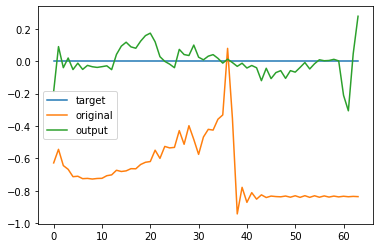

(0.7815996410971349, 2.5046852393730913e-14)
0.1993546038866043
0.1369142085313797
0.7815996408462524


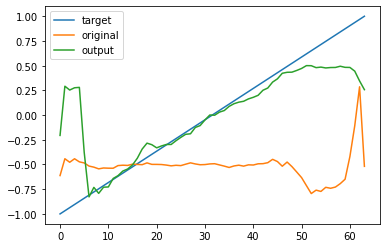

(nan, nan)
0.9028351902961731
0.9287046194076538
-2.7632722776615992e-08


/data/nils/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


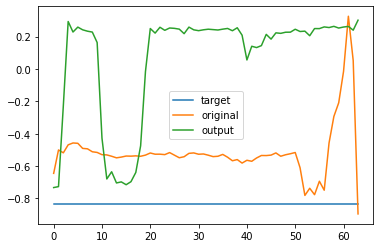

(0.6842594956961271, 4.5634009604779543e-10)
0.578199565410614
0.47627028822898865
0.6842595934867859


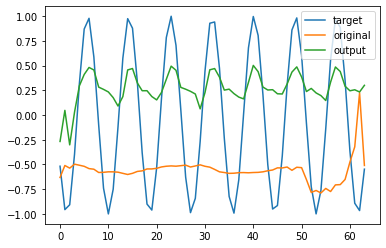

(0.807342744216696, 7.762165899227731e-16)
0.22459504008293152
0.12931010127067566
0.8073428273200989


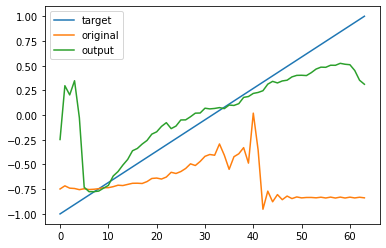

(nan, nan)
0.9629143476486206
0.9887151122093201
3.552713678800501e-09


/data/nils/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


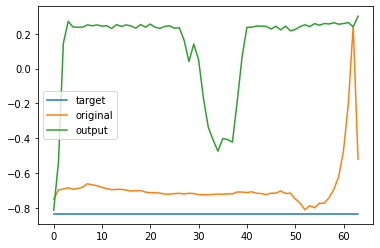

/data/nils/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(nan, nan)
1.0173548460006714
1.0965861082077026
6.394884621840902e-08


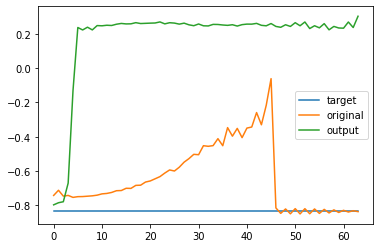

(0.3069679659566726, 0.013616388243554272)
0.6363615393638611
0.553458571434021
0.30696794390678406


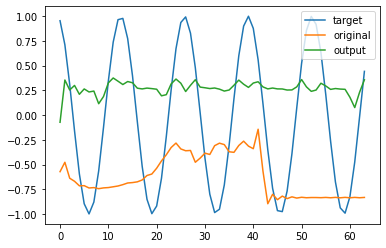

(0.8318785603706104, 1.6790955596183658e-17)
0.17903074622154236
0.062028393149375916
0.8318784832954407


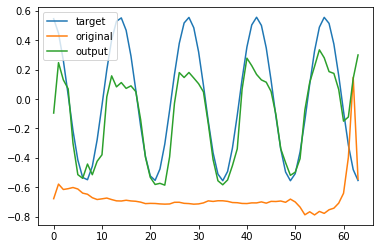

(0.2895611460510272, 0.020298032123785042)
0.6388656497001648
0.5564295053482056
0.2895611822605133


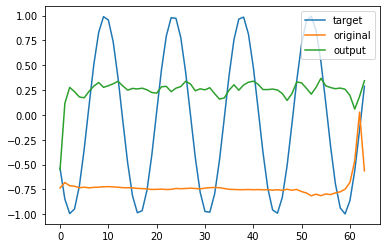

(nan, nan)
0.039663974195718765
0.0046377782709896564
0.0


/data/nils/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


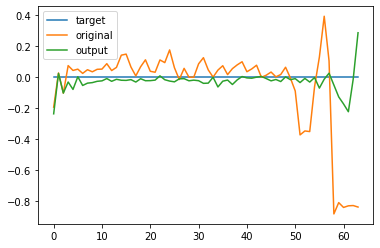

/data/nils/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(nan, nan)
1.2487802505493164
1.5622798204421997
0.0


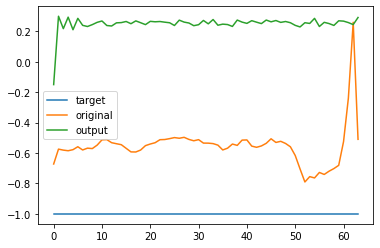

(-0.140483856129617, 0.2681979707932188)
1.0176281929016113
1.0744315385818481
-0.1404838263988495


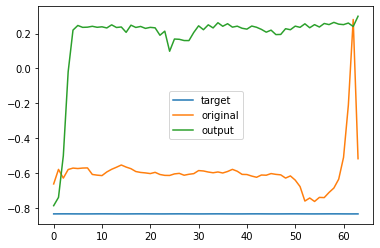

(0.5477191641489649, 2.811330770512359e-06)
0.40998154878616333
0.23861064016819
0.5477191209793091


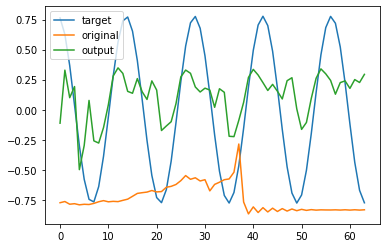

(0.7018479870912365, 1.0402235268721732e-10)
0.5958461165428162
0.4942735731601715
0.7018479108810425


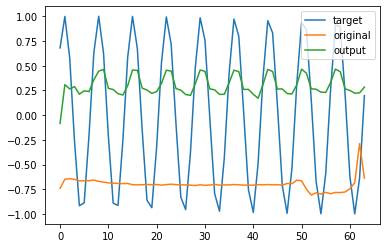

(nan, nan)
0.5232781767845154
0.2787590026855469
0.0


/data/nils/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


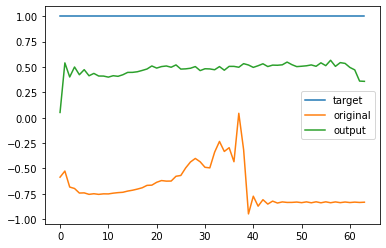

(-0.8604991917230421, 8.07769067399453e-20)
0.6891124248504639
0.8049694299697876
-0.8604992032051086


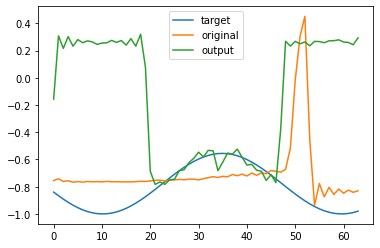

(0.30202127388170286, 0.015287969570973364)
0.614616870880127
0.5343360304832458
0.3020212948322296


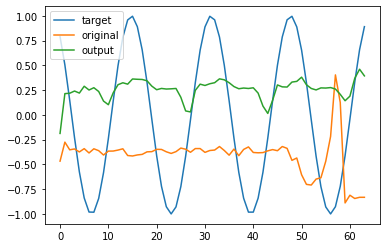

(-0.30255711935958485, 0.015098773293652916)
0.5233657360076904
0.6006497144699097
-0.3025571405887604


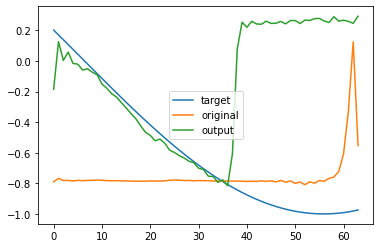

(0.486058283635062, 4.666627877840977e-05)
0.5180602073669434
0.4870379865169525
0.4860582649707794


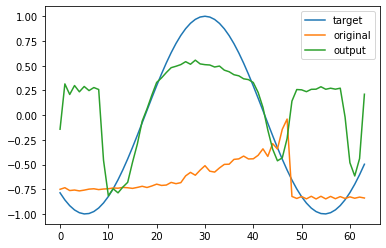

(0.40678393288524817, 0.0008510353937111897)
0.5410914421081543
0.5064812898635864
0.40678393840789795


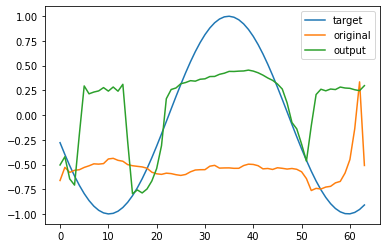

(0.6309514422055525, 2.2883727689321825e-08)
0.2760210335254669
0.2088015228509903
0.6309515833854675


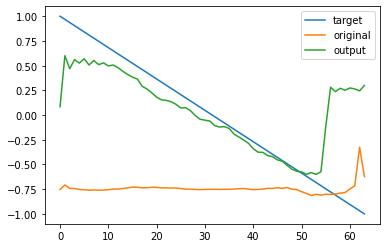

(0.6471711786958002, 7.540373802644225e-09)
0.5500774383544922
0.4403299391269684
0.6471712589263916


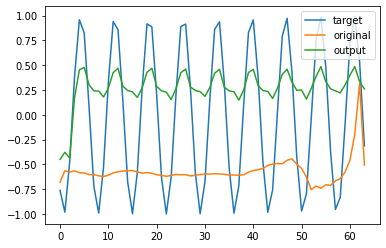

(0.8214818942682837, 9.151740099995108e-17)
0.3380844295024872
0.15059567987918854
0.8214819431304932


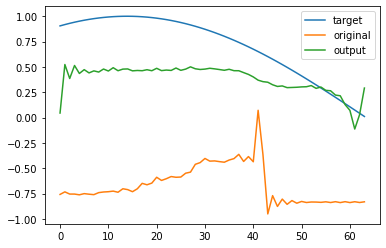

(0.6041193366203934, 1.2548250365135516e-07)
0.2822950482368469
0.21985706686973572
0.6041194200515747


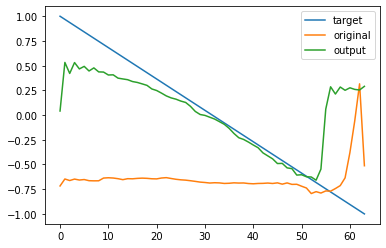

(0.27211972033945986, 0.02960900424285635)
0.6259891390800476
0.5251666307449341
0.2721197307109833


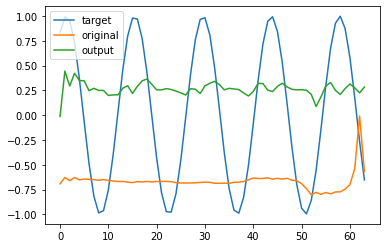

(0.8308600374385052, 1.9925702736208172e-17)
0.33521902561187744
0.14775948226451874
0.8308600783348083


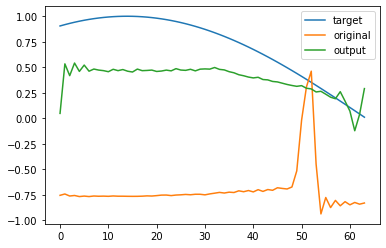

(nan, nan)
0.502884030342102
0.2569636106491089
0.0


/data/nils/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


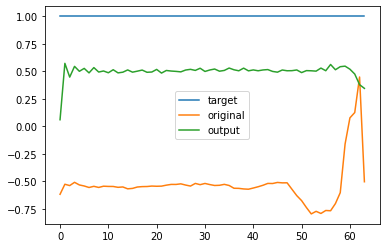

(-0.2254796531254199, 0.07322395082929152)
0.8813481330871582
0.8825218677520752
-0.22547964751720428


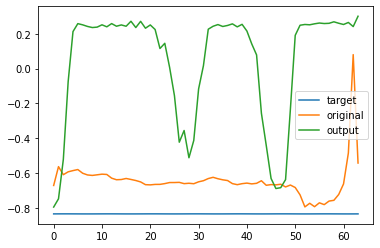

(0.14039337656573464, 0.2685094288855502)
0.6319282054901123
0.5377604961395264
0.14039339125156403


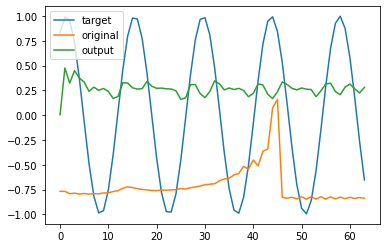

(-0.04335299606555434, 0.7337448240510888)
1.0390740633010864
1.1227312088012695
-0.04335298016667366


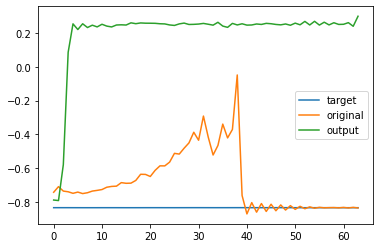

(nan, nan)
0.06988083571195602
0.0071720099076628685
0.0


/data/nils/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


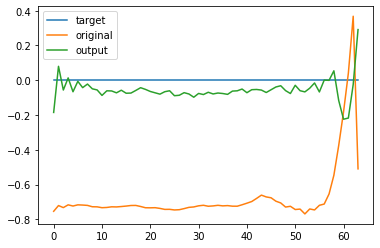

(0.6214860575960699, 4.248229354780683e-08)
0.2728455662727356
0.2127903252840042
0.6214861869812012


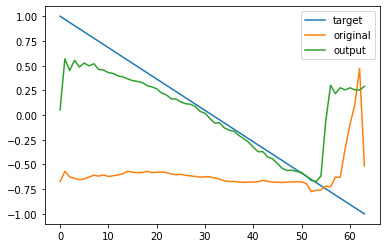

(-0.3008967187765627, 0.015691656411383748)
1.0253056287765503
1.1002962589263916
-0.3008967339992523


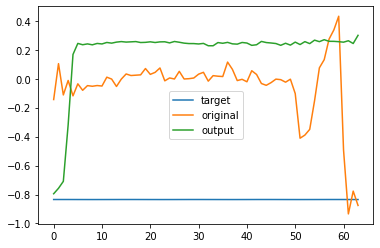

(0.9119195352817184, 1.146827740061835e-25)
0.1828451305627823
0.046176910400390625
0.9119194149971008


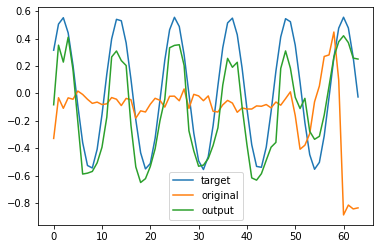

(0.9120419054776112, 1.1004907733129928e-25)
0.21253597736358643
0.07778044044971466
0.912041962146759


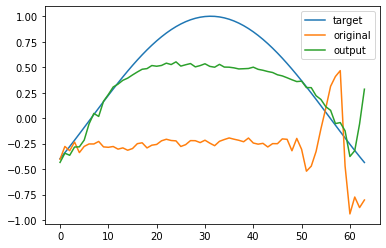

(-0.3512954243849046, 0.0044230812073681085)
0.8866909146308899
0.8658028841018677
-0.3512953221797943


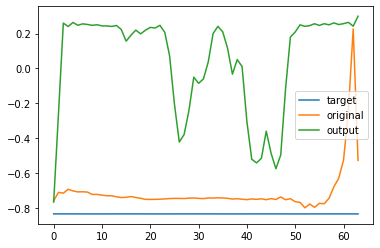

(0.0532999022128797, 0.6757330637138301)
0.9073232412338257
0.9330707788467407
0.05329989269375801


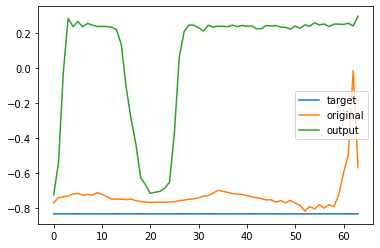

(0.5493726631889256, 2.5869318636038958e-06)
0.045880310237407684
0.005479577463120222
0.549372673034668


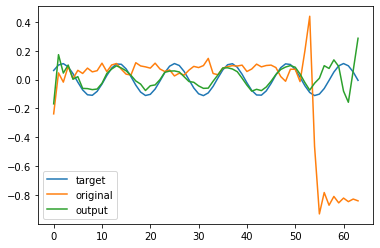

(0.9713305131106085, 2.1566555789013126e-40)
0.24679943919181824
0.09569033235311508
0.971330463886261


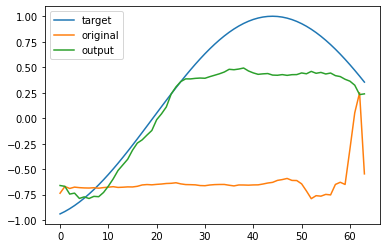

(0.030385642623882658, 0.8116103159255597)
0.9185340404510498
0.8945712447166443
0.030385645106434822


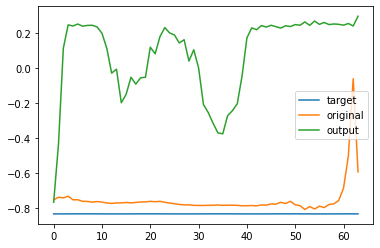

(0.8252930495299842, 4.979529221565039e-17)
0.20269840955734253
0.11821552366018295
0.8252931237220764


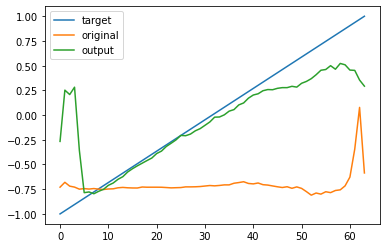

(nan, nan)
0.057436056435108185
0.006259615067392588
0.0


/data/nils/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


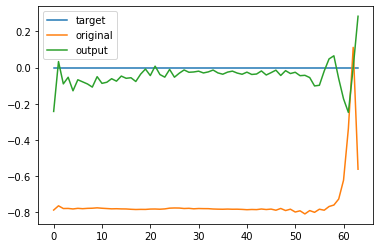

(-0.43267496166561026, 0.0003560273556317151)
1.0218749046325684
1.0955278873443604
-0.43267491459846497


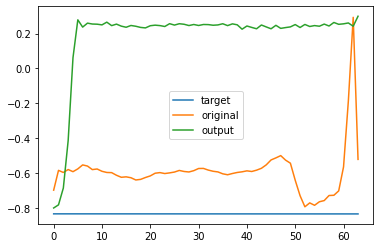

(0.8282730386604511, 3.0621862119213324e-17)
0.1893991082906723
0.06247474253177643
0.8282731175422668


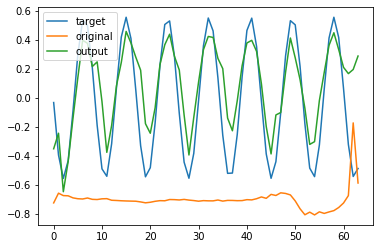

(-0.10145538640207238, 0.42504016361879265)
0.8629333972930908
0.840437114238739
-0.10145539790391922


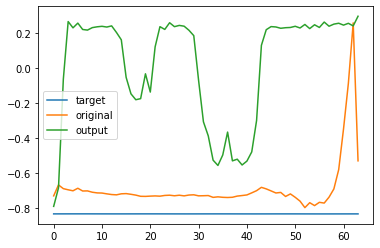

(nan, nan)
0.48378685116767883
0.23855936527252197
0.0


/data/nils/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


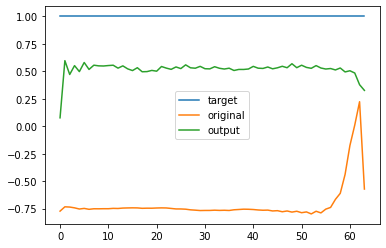

(0.9372521700395469, 4.5659731016460654e-30)
0.19306722283363342
0.0666736587882042
0.9372522830963135


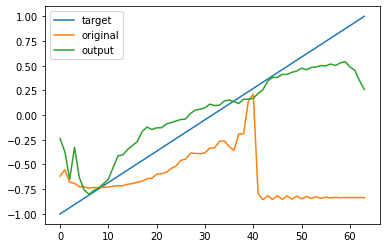

(0.960835576682187, 2.9248369188720027e-36)
0.1603700816631317
0.04333812743425369
0.9608355760574341


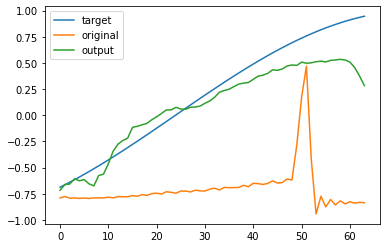

(-0.7568555442352142, 4.663026489742123e-13)
0.8249911665916443
0.8564344644546509
-0.7568554878234863


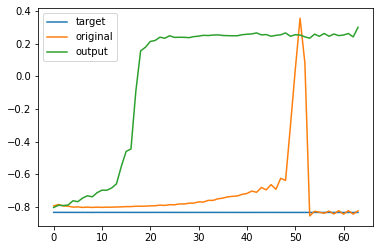

(-0.6712776636861029, 1.2746180844142802e-09)
0.2958601415157318
0.2529362738132477
-0.6712777018547058


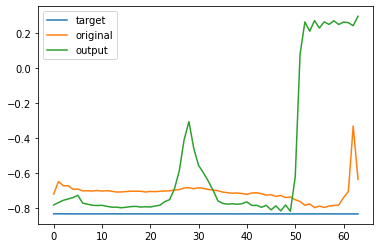

(-0.3557639500750098, 0.003913491491629831)
1.0516340732574463
1.1318962574005127
-0.35576388239860535


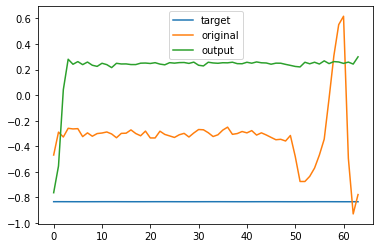

(0.5801191973536738, 5.061326774970699e-07)
0.5934092998504639
0.49005547165870667
0.580119252204895


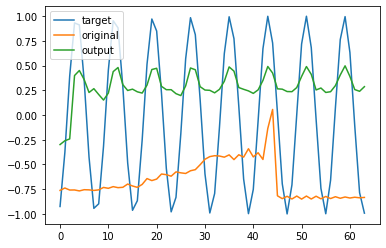

(-0.5097575774386199, 1.690054568826525e-05)
0.9921737313270569
1.0103273391723633
-0.5097575783729553


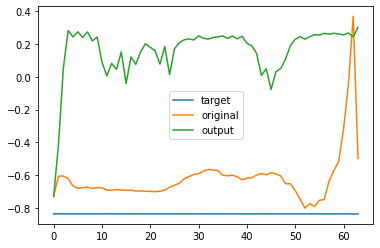

(-0.520343564723673, 1.0471915475114044e-05)
0.8730975985527039
0.8631260991096497
-0.520343542098999


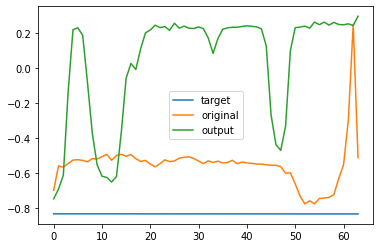

In [111]:
folder = models_path+"/results_new/"

feat_dict = torch.load(folder+"FRAVE_mono_swap_on_eval"+".pth")
swapped = feat_dict["swapped"]
true = feat_dict["in"]
out = feat_dict["out"]
for ex in range(20,80):
    for i,desc in enumerate(feat_dict["descriptors"]):
        plt.figure()
        
                    #Compute Correlation
        feat_out = out[ex,i]
        feat_in = swapped[ex,i]
        feat_l1loss = F.l1_loss(feat_in,feat_out).item()
        feat_l2loss = F.mse_loss(feat_in,feat_out).item()
        cos = torch.nn.CosineSimilarity(dim=0 ,eps=1e-6)
        corr = ((cos(feat_in.reshape(-1)-feat_in.mean(),feat_out.reshape(-1)-feat_out.mean()))).item()   
        
        print(stats.pearsonr(out[ex,i], swapped[ex,i]))
        print(feat_l1loss)
        print(feat_l2loss)
        print(corr)
        
        
        plt.plot(swapped[ex,i],label="target")
        plt.plot(true[ex,i],label="original")
        plt.plot(out[ex,i],label="output")
        plt.legend()
        plt.show()

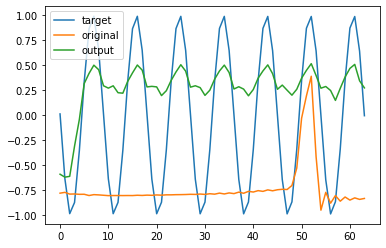

In [79]:
i=0
ex=3
plt.figure()
plt.plot(features_swapped[ex,i].cpu().numpy(),label="target")
plt.plot(features_norm[ex,i].cpu().numpy(),label="original")
plt.plot(features_out[ex,i].cpu().numpy(),label="output")
plt.legend()

In [69]:
features_swapped.shape

torch.Size([8, 1, 64])

In [81]:
df

,Manifold 80.0 %,Manifold 90.0 %,Manifold 95.0 %,step,JND,Mel Spec,MScale STFT,Cycle Consistency,Control L1 Error,Control Corr_centroid,Control Corr_rms,Control Corr_bandwidth,Control Corr_sharpness,Control Corr_booming
FRAVE_mono,13,40,66,600000,0.0,19.92661,5.124928,,,0.388311,,,,
CRAVE_mono,17,42,65,600000,0.0,16.618532,4.931892,,,0.398805,,,,


In [25]:
df

,Manifold 80.0 %,Manifold 90.0 %,Manifold 95.0 %,step,JND,Mel Spec,MScale STFT,Cycle Consistency,Control L1 Error,Control Corr_centroid,Control Corr_rms,Control Corr_bandwidth,Control Corr_sharpness,Control Corr_booming
FRAVE_mono,13,41,66,600000,0.0,19.981929,5.131976,,,0.462603,,,,
CRAVE_mono,17,42,65,600000,0.0,16.474937,4.92717,,,0.480384,,,,
